 ### Marius Nwobi 
 ##### Carnegie Mellon University: MS Data Analytics for Science 
 
 # Company Problems 

- They would like to understand the extent to which customers are satisfied or dissatisfied with their services and/or their overall relationship with the company(sentiment analysis)

- Furthermore, they are interested in what factor(s) might lead to satisfaction or dissatisfaction with products or services, or with SureStore as a service provider

- Would Like to know what might be under SureStore’s control to improve experiences

# Questions (for interview staff)
 
- What’s the demographic of this audience? (such as region, race, etc. since these can affect expectations)
 
- Can we assume that '- is NA or no response?
 
- Do we have access to the satisfactory score or only the primary reason? (If we don't is it up to us to interpret if a category is positive or negative? EX 'Time to handle/resolve claim' and 'Price' can be a good thing or a bad thing depending on the score they gave (high score then time was short, bad score then took a long time)?
 
- Is it safe to assume the 'Prim - Reason' column is formatted as a multiple choice question (since only 10 categories) while 'comments' column is a fill-in-the-blank type of question?
# More Questions 
- Are all of these responses from people who left a great satisfactory score? 
( mainly because of the bias in data found within EDA process)

 
- in REL dataset what does the category life mean? (Life insurance?)



# Plan of approach
1. Perform EDA to understand data more and trends with each column


1. Since I don’t have access to the scores, I'll perfrom sentiment analysis on the comments and create a labels based on good and bad comments to further understand what contibutes to a satisfaction or dissatisfaction. Can also use this to understand which groups(cts,scs, or rel) has a high or low customer satisfaction rate.
- Can use this to answer the first and second question question

1. If needed can perform LDA to get some topics to better understand overall factors

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
from nltk.sentiment import SentimentIntensityAnalyzer


import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# download('stopwords')



# Functions 

1. This function is used to remove stop words and frequent words( the stop_words + ['frequent words']) that cloud up the frequency plot and LDA Model.

( Making minimal viable product so avoiding rabbit whole of trying making best model's/plots by reomving all words, just trying to see if this overall process works )

In [2]:
def remove_stopwords(text):
    # importing stop words from NLTK 
    stop_words = stopwords.words('english')
    # removing these words also because it's clouding frequency plot 
    stop_words = stop_words + ['surestore','claim','always','service','would','accident'] 
    # Tokenize and remove stop words and puncation
    tokens = re.findall(r'\b\w+\b', text.lower())
    filtered_tokens = [word for word in tokens 
                      if word not in stop_words 
                      and len(word) > 1] # greater than 1 to make sure letters aren't added
    return ' '.join(filtered_tokens)

2. This function will be used for the REL dataset when I do sentiment analysis to remove the comments that have an integer as a response

In [3]:
def is_not_integer(text):
    try:
        float(str(text))
        return False
    except ValueError:
        return True

# Reading in data 

In [4]:
cts=pd.read_excel('/Users/mariusnwobi/Downloads/Vangaurd/CTS Data.xlsx')
rel=pd.read_excel('/Users/mariusnwobi/Downloads/Vangaurd/REL Data.xlsx')
scs=pd.read_excel('/Users/mariusnwobi/Downloads/Vangaurd/SCS Data.xlsx')

# EDA on CTS dataset (people who had a claim)

### Ensuring shape of data is correct

In [5]:
cts.tail() # shows more useful info than cts.head()

,CTS ID,CTS Resp ID,CTS Interview End Date,CTS - Prim Reason,CTS - Reason Comments
9734,9736,A486584,2019-11-21,Representative's friendly and caring service,'-
9735,9737,A4865XA,2019-11-23,Representative's friendly and caring service,'-
9736,9738,A48660A,2019-11-20,Time to Handle/Resolve Claim,'-
9737,9739,A486606,2019-11-20,Representative's friendly and caring service,"Absolutely recommend SureStore to everyone, ba..."
9738,9740,A4866A4,2019-11-13,Representative's friendly and caring service,Every interaction I've had when doing anything...


### Along with the data types

In [6]:
print(cts.dtypes)
print(cts.shape)

CTS ID                             int64
CTS Resp ID                       object
CTS Interview End Date    datetime64[ns]
CTS - Prim Reason                 object
CTS - Reason Comments             object
dtype: object
(9739, 5)


Checking for Na's

In [7]:
cts.isna().sum().sum()

np.int64(17)

In [8]:
cts[cts.isna().any(axis=1)]

,CTS ID,CTS Resp ID,CTS Interview End Date,CTS - Prim Reason,CTS - Reason Comments
1189,1191,A448436,2019-02-21,Time to Handle/Resolve Claim,NaN
1525,1527,A44X56X,2019-02-27,Representative's friendly and caring service,NaN
1692,1694,A450A25,2019-02-20,Other,NaN
1922,1924,A45A226,2019-03-07,Representative's friendly and caring service,NaN
2165,2167,A452A6X,2019-03-13,Time to Handle/Resolve Claim,NaN
2459,2461,A4533A3,2019-03-27,Other,NaN
2601,2603,A45387X,2019-03-28,Other,NaN
3412,3414,A456863,2019-04-25,Representative's friendly and caring service,NaN
3611,3613,A4576A2,2019-04-24,Time to Handle/Resolve Claim,NaN
3898,3900,A458X07,2019-05-08,Time to Handle/Resolve Claim,NaN


Dropping Na's because it's only a small subset of the data

In [9]:
cts=cts.dropna()

Looking at distribution of data 

In [10]:
cts.describe(include='all')

,CTS ID,CTS Resp ID,CTS Interview End Date,CTS - Prim Reason,CTS - Reason Comments
count,9722.000000,9722,9722,9722,9722
unique,NaN,9722,NaN,10,6794
top,NaN,A4866A4,NaN,Representative's friendly and caring service,'-
freq,NaN,1,NaN,3577,2770
mean,4872.265892,NaN,2019-06-08 22:56:00.789961216,NaN,NaN
min,2.000000,NaN,2019-01-01 00:00:00,NaN,NaN
25%,2437.250000,NaN,2019-03-20 00:00:00,NaN,NaN
50%,4873.500000,NaN,2019-06-05 00:00:00,NaN,NaN
75%,7306.750000,NaN,2019-08-21 00:00:00,NaN,NaN
max,9740.000000,NaN,2019-12-31 00:00:00,NaN,NaN


A little over 1/3 of the Primary reasoning was because of 'friendly and caring service'. Also, notice that almost 25-30 percent of the comments were blank/NA so this can affect how I can use sentiment analysis to make my labels.

 
For the Primary reason of leaving a customer satisfactory report, there are only 10 types of responses while we can see that there are a bunch of different comments.

In [11]:
percentage = (len(cts[cts['CTS - Reason Comments'] != "'-"]) / 
             len(cts['CTS - Reason Comments'])) * 100

print(f'The amount of people who left a comment is {np.round(percentage, 2)}%')

The amount of people who left a comment is 71.51%


### Looking at distribution for the different types of reasonings since this is categorical

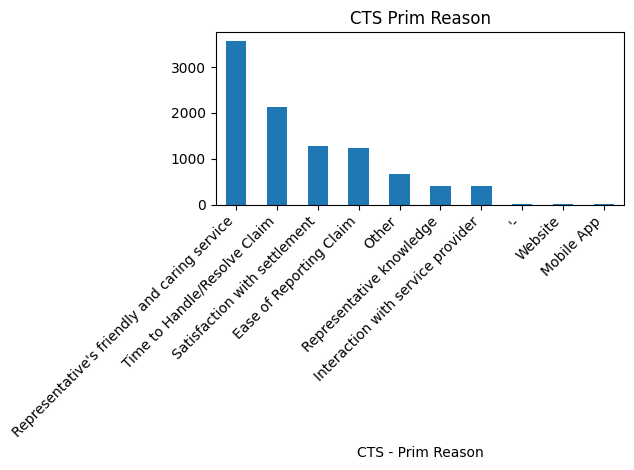

In [12]:
cts['CTS - Prim Reason'].value_counts().plot(kind='bar')
plt.title('CTS Prim Reason')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

As we can see these categories aren't evenly distributed and the majority of the reasons are positive comments

## Looking at distribution by month 

/var/folders/z3/hk1dpf0j2zvfqlhp4phng96r0000gn/T/ipykernel_14328/3630100936.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_all = (cts.groupby([pd.Grouper(key='CTS Interview End Date', freq='M'),
/var/folders/z3/hk1dpf0j2zvfqlhp4phng96r0000gn/T/ipykernel_14328/3630100936.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


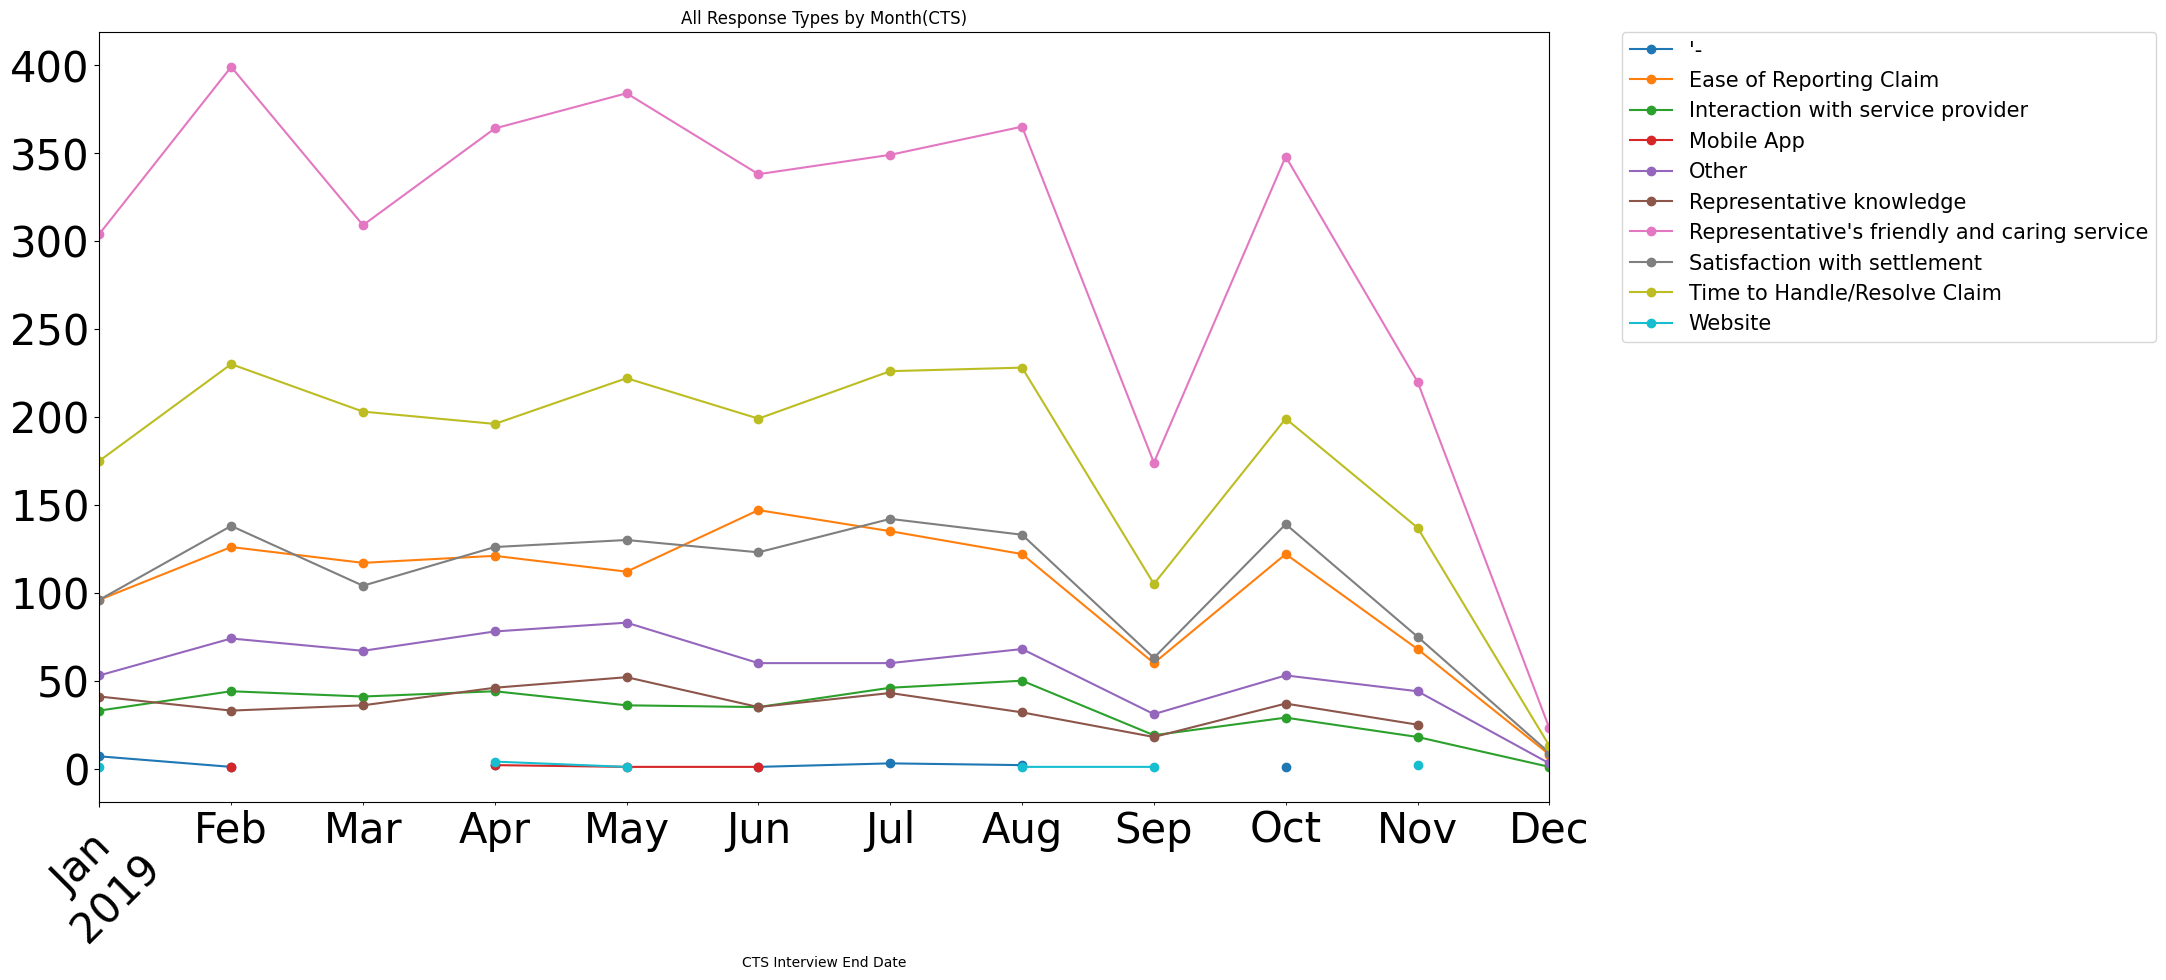

In [13]:
monthly_all = (cts.groupby([pd.Grouper(key='CTS Interview End Date', freq='M'), 
                          'CTS - Prim Reason']).size().unstack())

# Creating plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot on the axis
monthly_all.plot(kind='line', marker='o', ax=ax,fontsize=30)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('All Response Types by Month(CTS)')

# Move legend outside and adjust layout
ax.legend(bbox_to_anchor=(1.05, 1), 
         loc='upper left', 
         fontsize=15, 
         borderaxespad=0)
         

# Adjust layout to prevent legend cutoff
plt.subplots_adjust(right=0.85)

Not necessary but looking at customer volume might play a role.

Ex.

The month Sep might have the best reports overall due to a low customer volume so better services as compared to Feb or Aug where there are almost double the customers compared to September.

( Might affect time to file a claim or reach representative)





## Word frequency plot for 'comments' column 

Amount of people who left a comment on their surveys

Below I'm removing stopwords, and finding the word frequency in the whole dataset 

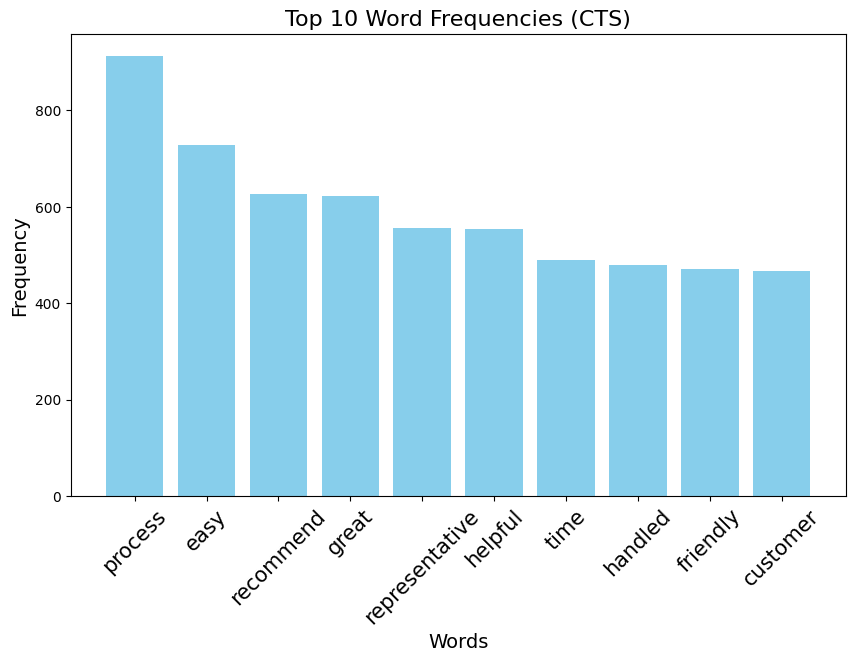

In [14]:
# Apply function to column to remove stop words
ctscomment_no_sw= cts['CTS - Reason Comments'].apply(remove_stopwords) 

# Combine all text into a single string to make it easier to count words
all_text = ' '.join(ctscomment_no_sw)

# Tokenize: remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text)

# Count word frequencies
word_freq = Counter(tokens)

# Get the top 10 most common words
top_n = 10
common_words = word_freq.most_common(top_n)
# breaking apart top common words to make it easy to graph
words, counts = zip(*common_words) 

# Graphing word frequencies
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies (CTS)', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


Based on some of these words, we can tell that a bulk of the comments were positive based on words such as easy, great, friendly, helpful, etc. Also, most of these words sound as though they are directed towards the representatives or the overall process.

Although there is still some info left out there can still be some assumptions such as...

1. The process was easy
1. They would recommend this to someone else
1. They liked the way things were handled

Have to consider words such as recommend, time, and process since they could lead to negative feedback or a critique, but this wouldn’t be the case if all of our data were from customers who left a positive satisfactory score.

( hint need to seperate into positive and negative to draw a better picture )

# REL EDA (no change at all)

checking Na's 

In [15]:
print(rel.shape)
rel.isna().sum().sum()

(50234, 6)


np.int64(26)

In [16]:
rel[rel.isna().any(axis=1)]

,REL ID,REL Respid,Combined Interview End Date,REL Primary Reason,REL Reason Other,REL Primary Reason Comments
4015,4017,423367,2017-03-27,Price,NaN,It's affordable
4443,4445,427047,2017-04-04,Claims Service,NaN,The reason that I have stayed with SureStore f...
6798,6800,448A08,2017-05-30,reason_99_other,NaN,"I would recommend SureStore, but I am not usua..."
7365,7367,453234,2017-06-05,Policy Service - Non Claims,'-,NaN
8995,8997,470A6A,2018-01-30,Reputation,'-,NaN
9501,9503,474608,2018-02-12,Product Offerings,'-,NaN
15612,15614,534083,2018-06-04,Price,'-,NaN
15838,15840,536330,2018-06-04,Reputation,'-,NaN
15864,15866,53670A,2018-06-04,Website,NaN,its the most important aspect of the insurance...
19020,19022,566420,2018-08-27,reason_99_other,NaN,NaN


Chose to drop both the Na's in 'REL Reason Other' and 'REL Primary Reason Comments'. Might go back and add/use the Na's in 'REL Reason Other' if I need more data for my LDA model to derive better topics.

In [17]:
rel=rel.dropna()

Checking the data types

In [18]:
rel.dtypes

REL ID                                  int64
REL Respid                             object
Combined Interview End Date    datetime64[ns]
REL Primary Reason                     object
REL Reason Other                       object
REL Primary Reason Comments            object
dtype: object

Looking at data distribution 

In [19]:
rel.describe(include='all')

,REL ID,REL Respid,Combined Interview End Date,REL Primary Reason,REL Reason Other,REL Primary Reason Comments
count,50209.000000,50209,50209,50209,50209,50209
unique,NaN,50209,NaN,12,826,26606
top,NaN,X0067X,NaN,Claims Service,'-,'-
freq,NaN,1,NaN,12654,49157,21932
mean,25117.907726,NaN,2019-01-21 21:31:24.498795008,NaN,NaN,NaN
min,2.000000,NaN,2017-01-09 00:00:00,NaN,NaN,NaN
25%,12560.000000,NaN,2018-04-04 00:00:00,NaN,NaN,NaN
50%,25117.000000,NaN,2019-03-11 00:00:00,NaN,NaN,NaN
75%,37676.000000,NaN,2020-01-06 00:00:00,NaN,NaN,NaN
max,50235.000000,NaN,2020-12-27 00:00:00,NaN,NaN,NaN


Less than 1 percent had chosen 'other' outside of the 11 options. 43% of the people who responded to this survey report didn't leave a comment. Around 25 percent of the people chose 'Claims Service' as a reason for satisfaction 

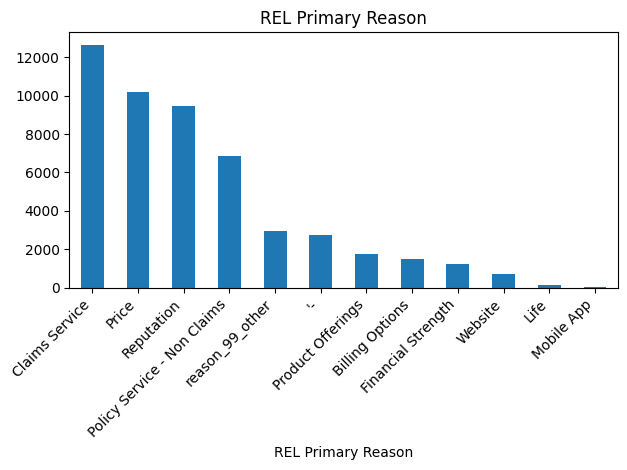

In [20]:
rel['REL Primary Reason'].value_counts().plot(kind='bar')
plt.title('REL Primary Reason')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Confused about what 'reason_99_other' means. I understand that people were directed to the 'REL Reason Other' if they selected 'other' in the 'Prim Reason' column, but roughly 3,000 people selected 'other' out of the 12 options but only 800-900 left an actual reason separate from '-.


Categories are less descriptive and more open-ended compared to CTS so results or harder to determine ( need more of a domain knowledge to understand reputation, claim service, products overing,etc )

Also noticed that since these people didn't file a claim or changed their policy, they might value other things hence the difference in choices.(no comments about represenative) Overall sounds as though they value the prices and service/policies better than they do the representatives.

Similar distribution to CTS where categories aren't evenly distributed and there are dominant categories.





### Creating timeseries plot 

/var/folders/z3/hk1dpf0j2zvfqlhp4phng96r0000gn/T/ipykernel_14328/2308641362.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_all = (rel.groupby([pd.Grouper(key='Combined Interview End Date', freq='M'),
/var/folders/z3/hk1dpf0j2zvfqlhp4phng96r0000gn/T/ipykernel_14328/2308641362.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


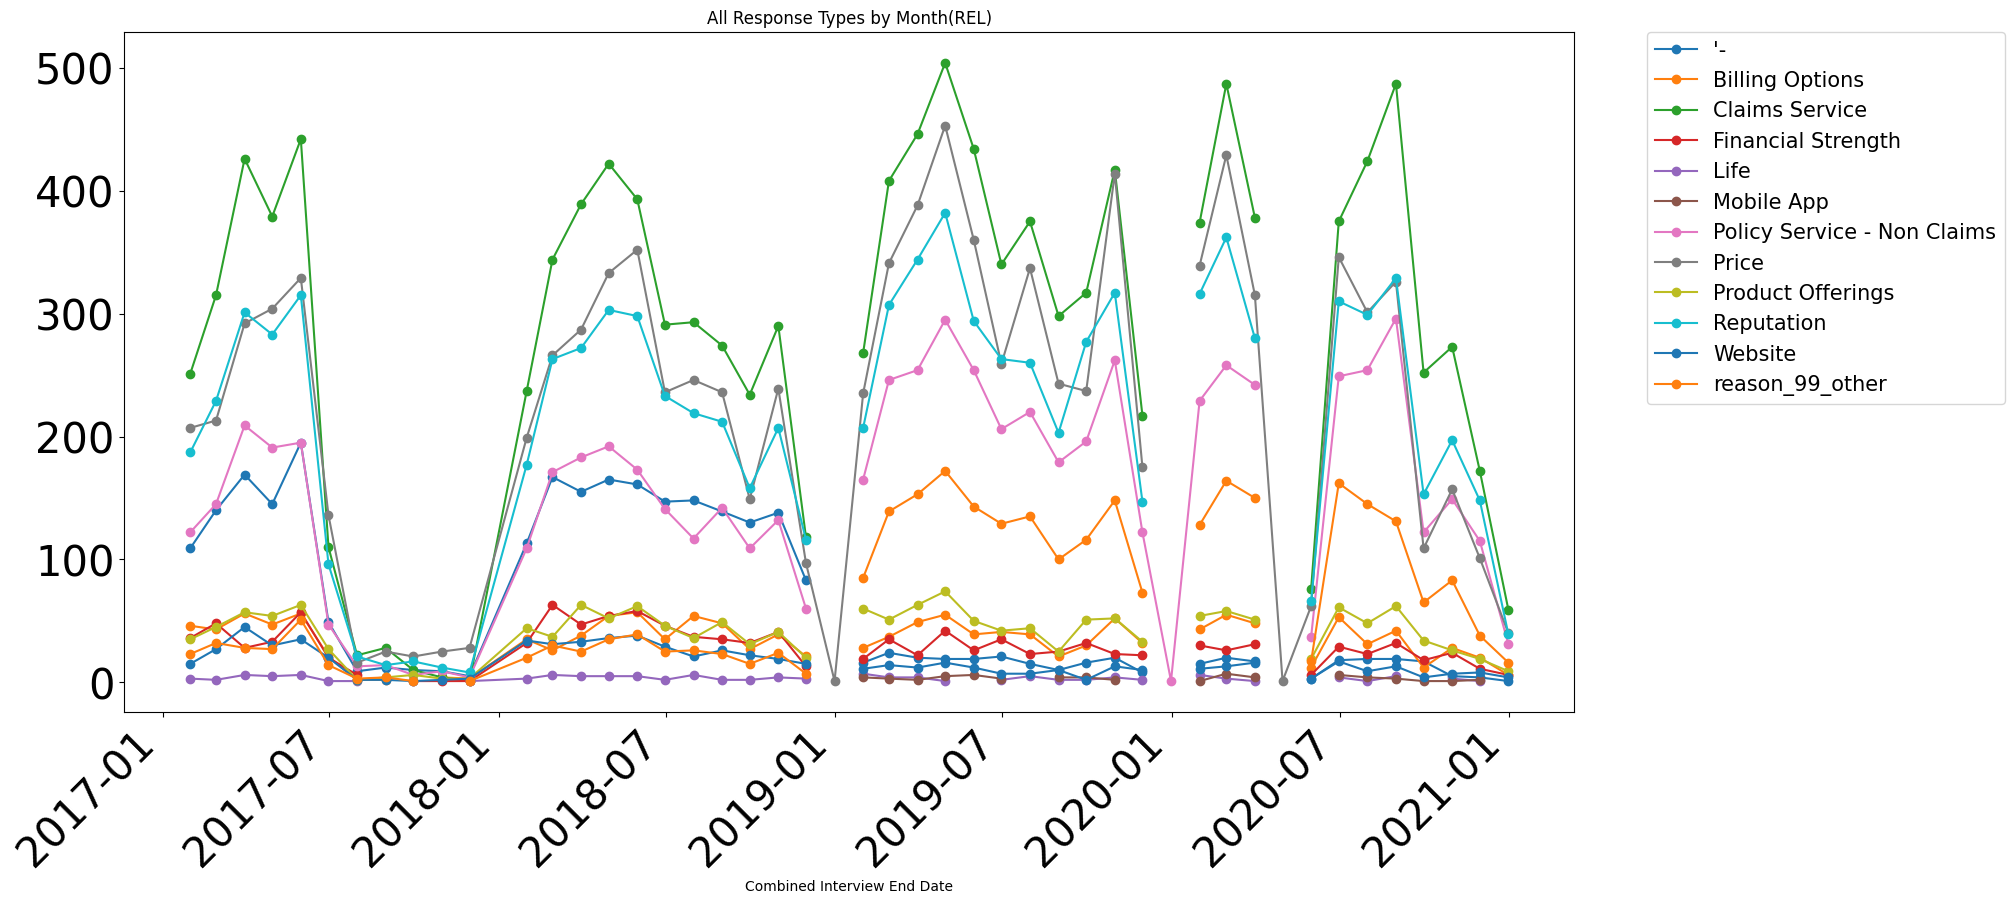

In [21]:
monthly_all = (rel.groupby([pd.Grouper(key='Combined Interview End Date', freq='M'), 
                          'REL Primary Reason']).size().unstack())

# Plotting Visuals 
fig, ax = plt.subplots(figsize=(20, 10))
# Plot on the axis
monthly_all.plot(kind='line', marker='o', ax=ax,fontsize=30)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('All Response Types by Month(REL)')

# Move legend outside and adjust layout
ax.legend(bbox_to_anchor=(1.05, 1), 
         loc='upper left', 
         fontsize=15, 
         borderaxespad=0)

# Adjust layout to prevent legend cutoff
plt.subplots_adjust(right=0.85)



We can see the seasonality trend where there is a peak every year during May-June ( except for 2020 where the peak came during August-September) and a fast decrease into December(except for 2017 where this occurred in July ).

## Word Frequency plot for comments

Same method/ code for cts just changed the column name and dataset

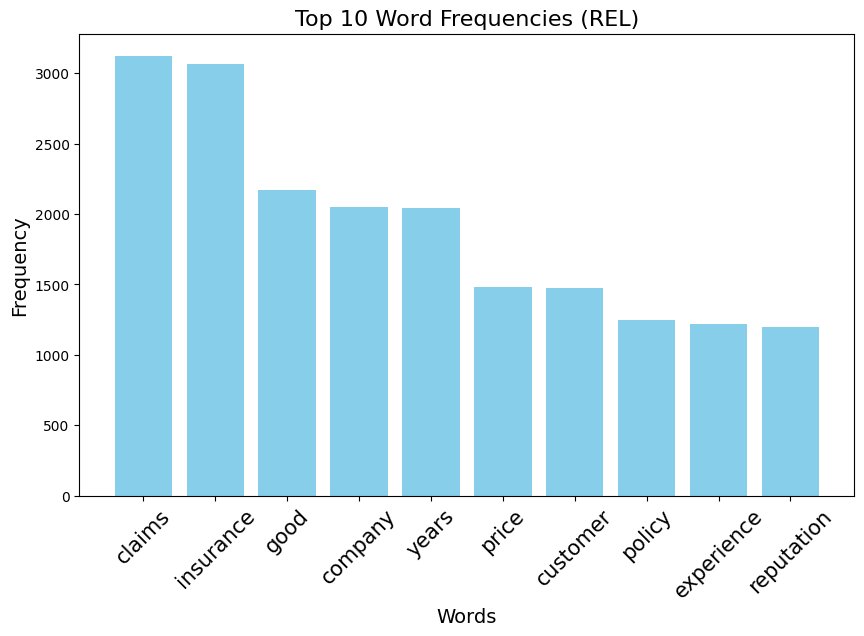

In [22]:
# Applying this function to remove comments that are just numbers to make plot 
rel_no_ints = rel[rel['REL Primary Reason Comments'].apply(is_not_integer)].reset_index()
# Removing stop words
relcomment_no_sw= rel_no_ints['REL Primary Reason Comments'].apply(remove_stopwords)


# Combine all text into a single string
all_text = ' '.join(relcomment_no_sw)

# Tokenize: Convert to lowercase, remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text.lower())

# Count word frequencies
word_freq = Counter(tokens)

# Get the top N most common words
top_n = 10
common_words = word_freq.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies (REL)', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


We can see that this isn't as helpful, but we can see words such as reputation, experince, and price which could lead to a positive satisfactory score.

The majority of these words are tailored towards the company and the policies, not representatives, so they value these more instead of the reps

# SCS EDA (policy change)

Checking Na's and dropping

In [23]:
print(scs.isna().sum())
print(scs.shape)

SCS ID                           0
SCS Respid                       0
Combined Interview End Date      0
SCS Primary Reason               0
SCS Primary Reason Other         0
SCS Reason Comments            138
dtype: int64
(39946, 6)


In [24]:
scs=scs.dropna()

# if I need the data I could go back and use there suggestions from the
# 'Prim Reason' column instead of just dropping the whole row.

Checking the data types

In [25]:
scs.dtypes

SCS ID                                  int64
SCS Respid                             object
Combined Interview End Date    datetime64[ns]
SCS Primary Reason                     object
SCS Primary Reason Other               object
SCS Reason Comments                    object
dtype: object

Looking at data structure

In [26]:
scs.tail() # provides more info when doing tail

,SCS ID,SCS Respid,Combined Interview End Date,SCS Primary Reason,SCS Primary Reason Other,SCS Reason Comments
39941,39943,632635,2020-12-22,Friendly/Caring Rep,'-,'-
39942,39944,632640,2020-12-16,Ease to do Business,'-,'-
39943,39945,632643,2020-12-16,Ease to do Business,'-,'-
39944,39946,632657,2020-12-29,Friendly/Caring Rep,'-,'-
39945,39947,632660,2020-12-23,Friendly/Caring Rep,'-,'-


Looking at distribution of data

In [27]:
scs.describe(include='all')

,SCS ID,SCS Respid,Combined Interview End Date,SCS Primary Reason,SCS Primary Reason Other,SCS Reason Comments
count,39808.000000,39808.0,39808,39808,39808,39808
unique,NaN,39808.0,NaN,11,1239,19576
top,NaN,632545.0,NaN,Friendly/Caring Rep,'-,'-
freq,NaN,1.0,NaN,14731,38320,19097
mean,19976.841816,NaN,2019-01-05 22:28:20.160771584,NaN,NaN,NaN
min,2.000000,NaN,2017-01-26 00:00:00,NaN,NaN,NaN
25%,9993.750000,NaN,2018-02-06 00:00:00,NaN,NaN,NaN
50%,19979.500000,NaN,2019-01-30 00:00:00,NaN,NaN,NaN
75%,29963.250000,NaN,2020-02-04 00:00:00,NaN,NaN,NaN
max,39947.000000,NaN,2020-12-29 00:00:00,NaN,NaN,NaN


About 37% of the people chose 'Friendly/Caring Rep' as a reason and 47% of the poeple didnt leave a comment

Viewing Distribution of Primary Reasons

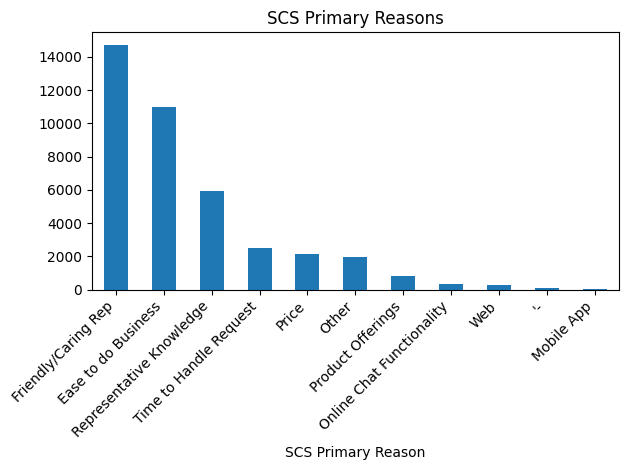

In [28]:
scs['SCS Primary Reason'].value_counts().plot(kind='bar')
plt.title('SCS Primary Reasons')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Similar data distribution to the cts and rel data set, almost all of the categories can lead to a positive satisfactory score. This crowd( people who have policy changes) values the reps and the process more than the company it seems. They didn’t value the price or time to handle the request as much, so this might be some areas of improvement. 

View Responses over time

/var/folders/z3/hk1dpf0j2zvfqlhp4phng96r0000gn/T/ipykernel_14328/3543866227.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_all = (scs.groupby([pd.Grouper(key='Combined Interview End Date', freq='M'),
/var/folders/z3/hk1dpf0j2zvfqlhp4phng96r0000gn/T/ipykernel_14328/3543866227.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


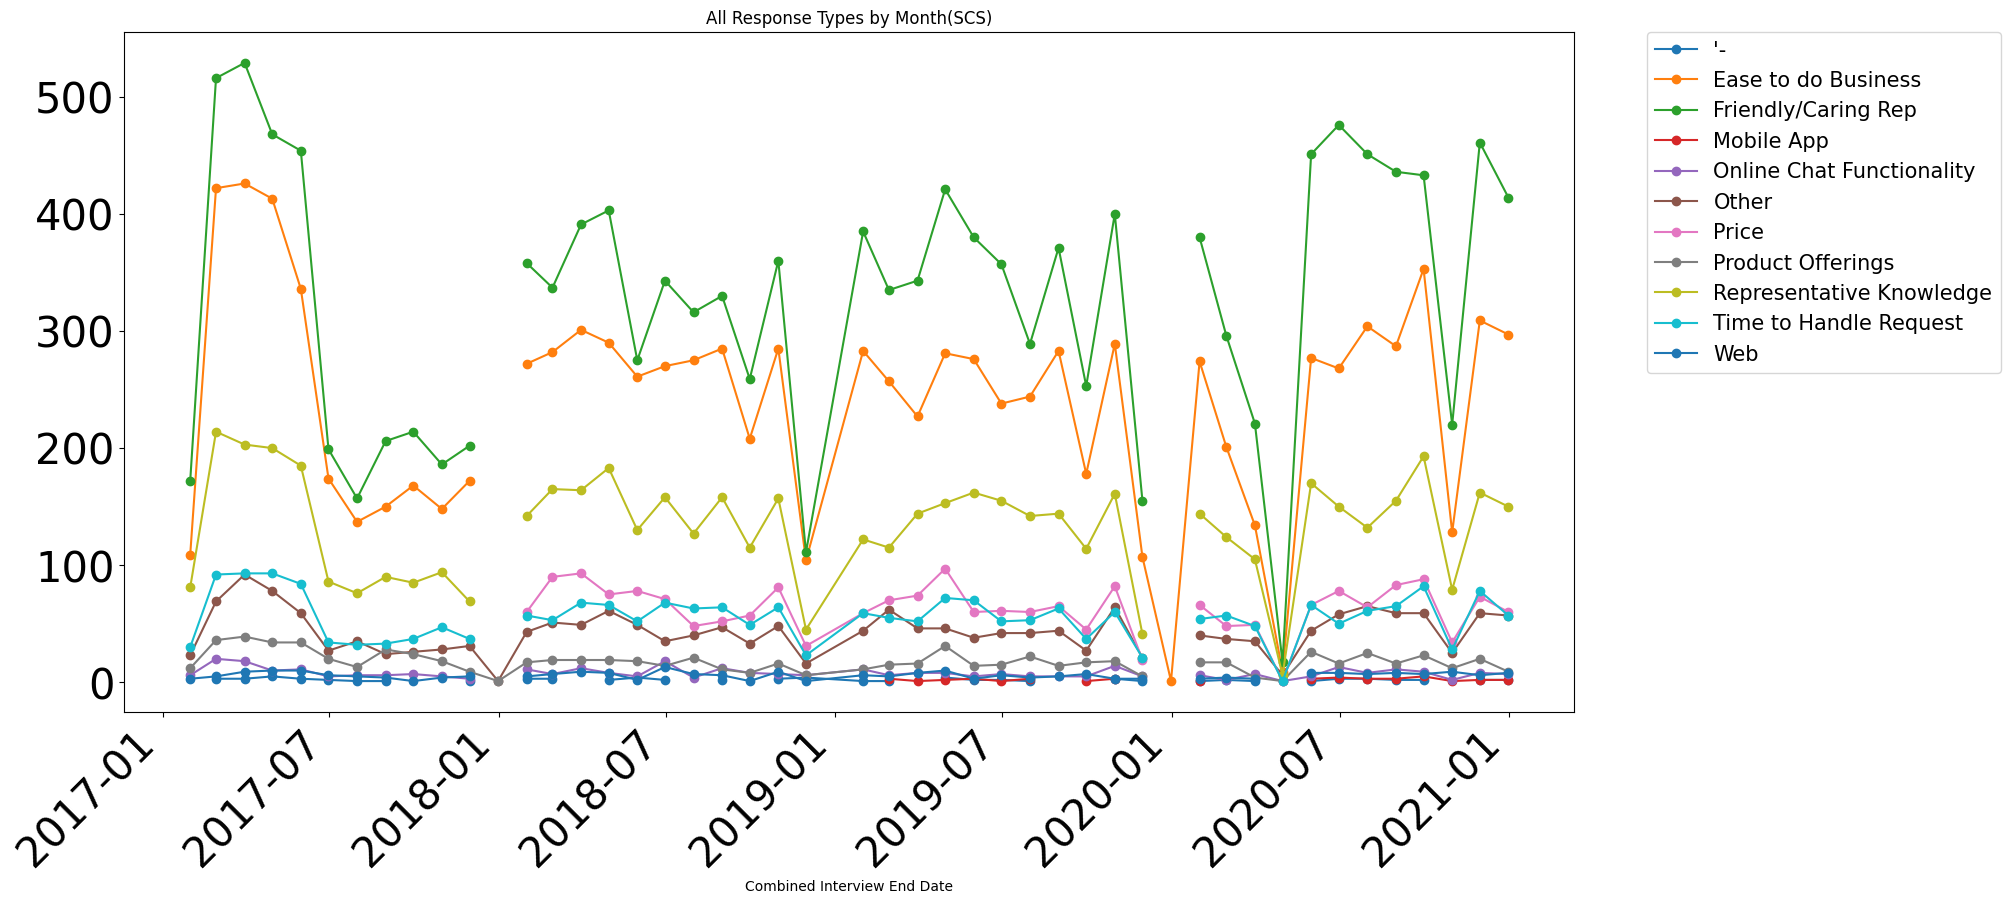

In [29]:
monthly_all = (scs.groupby([pd.Grouper(key='Combined Interview End Date', freq='M'), 
                          'SCS Primary Reason']).size().unstack())

# Plotting Visuals 
fig, ax = plt.subplots(figsize=(20, 10))
# Plot on the axis
monthly_all.plot(kind='line', marker='o', ax=ax,fontsize=30)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('All Response Types by Month(SCS)')

# Move legend outside and adjust layout
ax.legend(bbox_to_anchor=(1.05, 1), 
         loc='upper left', 
         fontsize=15, 
         borderaxespad=0)

# Adjust layout to prevent legend cutoff
plt.subplots_adjust(right=0.85)


This dataset follows a similar trend to REL data set in regards to the seasonality and how the lows are the same.

Only difference is the peaks, they occur a little earlier around April-May


## Word frequency for comments

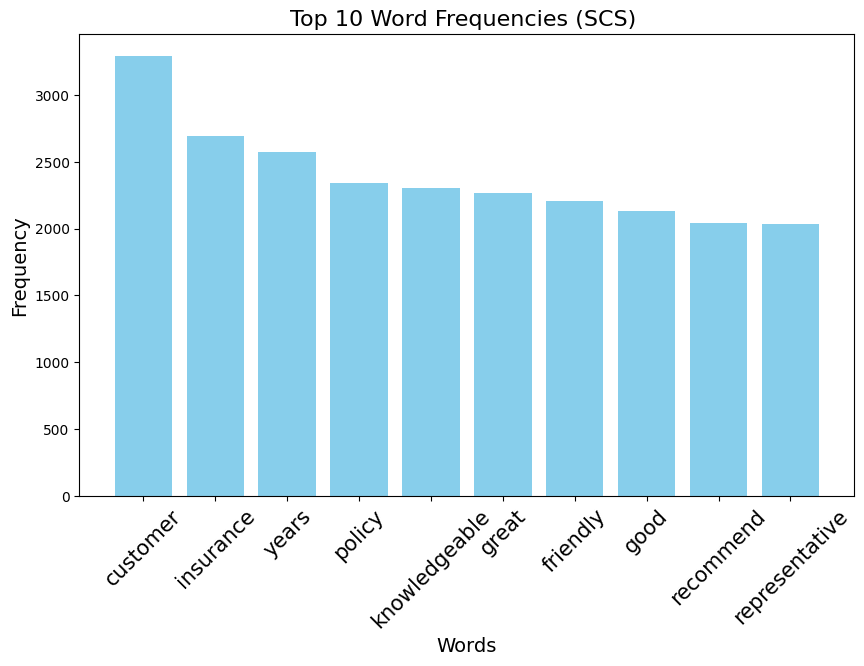

In [30]:
scscomment_no_sw= scs['SCS Reason Comments'].apply(remove_stopwords)


# Combine all text into a single string
all_text = ' '.join(scscomment_no_sw)

# Tokenize: Convert to lowercase, remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text.lower())

# Count word frequencies
word_freq = Counter(tokens)

# Get the top N most common words
top_n = 10
common_words = word_freq.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies (SCS) ', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


We can see some positive words such as great, friendly, good, and knowledgeable.

These words are tailored toward the process/policies and the reps 

## Plan of approach for Sentiment Analysis

1. Use sentiment intensity analysis to make labels for all of the comments and make a new labeled column.

1. Make a frequency plot based on labels and then perform LDA to determine some topics from the negative comments and positive comments (from the label)
(https://scikit-learn.org/1.5/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
)

1. If time permits, make a new dataset by combining all comments from all 3 datasets and then creating frequency plots and LDA models based on class.


## Performing Sentiment analysis and creating a label for positive or negative on datasets to further deep dive into negative and positive comments to understand areas of improvements

Using SentimentIntensityAnalyzer because this accounts for capitalization, punctuation, and modifiers that affect neighboring words. The only downside is that it's poor with irony or jokes.

Using 'compound' output in SentimentIntensityAnalyzer() to determine classes because this is an overall sentiment based on the positive and neutral values

(https://hex.tech/templates/sentiment-analysis/vader-sentiment-analysis/)

I fully understand that Sentiment analysis might incorrectly classify some data but assuming the difference is marginal. To mitigate, I made the threshold >=0 ('compound' score has to be greater or equal to 0) to be classified as a positive comment 

Ex use case

In [31]:
cts['CTS - Reason Comments'][8]

'Ms. Bradshaw has been very pleasant to work with. She has reached out to me to make sure everything is going fine.'

In [32]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores((cts['CTS - Reason Comments'][8]))

{'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'compound': 0.796}

Clearly a positive comment and 'compound' supports this while showing a break breakdown of pos,neg, and neutral sentiment

## Filtering data and making labels for CTS dataset 

0 is good and bad is 1

In [33]:
# Filtering data
cts_comments=cts[cts['CTS - Reason Comments']!= "'-"].reset_index()
# Labeling data
comment_label=[]
for i in range(len(cts_comments['CTS - Reason Comments'])):
        if sia.polarity_scores((cts_comments['CTS - Reason Comments'][i]))['compound']>=0:
            comment_label.append(0)
        else:
            comment_label.append(1)

cts_comments['com_label']=comment_label

Viewing class distibution

In [34]:
cts_comments['com_label'].value_counts()

com_label
0    6208
1     744
Name: count, dtype: int64

Majority of the comments left were positive and there's a sever class imbalance

### Visual

<Axes: title={'center': 'CTS Class Distribution'}, xlabel='com_label'>

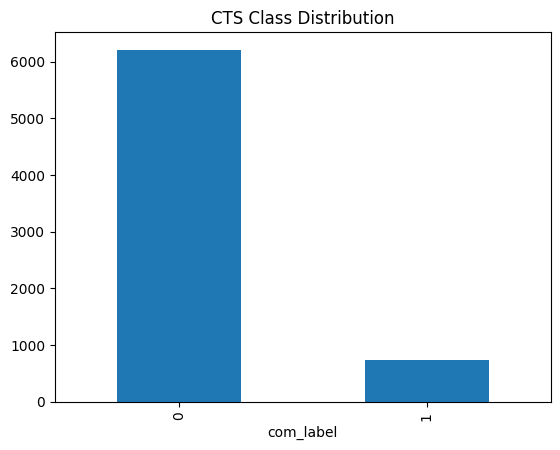

In [35]:
cts_comments['com_label'].value_counts().plot(kind='bar',title= 'CTS Class Distribution')

In [36]:
(cts_comments['com_label'].value_counts()[1]/cts_comments['com_label'].value_counts()[0]) *100

np.float64(11.984536082474227)

12% of the comments left a negative feedback

# Analyzing CTS for bad Comments
creating freqency plot and LDA model to analyse majority of the bad comments

In [37]:
cts_comments['CTS - Reason Comments'][cts_comments['com_label']==1]

8                                          Not satisfied.
14      As I said above not in once in 25 years of cov...
16      The one unpleasant situation with my claim was...
20      No arguments about getting repairs done, just ...
38                                    Repaired all damage
                              ...                        
6917    Dear SureStore,     My claim is still open and...
6929    The SureStore claims team made the stress of h...
6932    The representative who handled this claim had ...
6934    I had to manage my claim. I could never get a ...
6938    it saved me the burden of having to deal with ...
Name: CTS - Reason Comments, Length: 744, dtype: object

making a frequency plot based on the bad comments found by sentiment analyzer

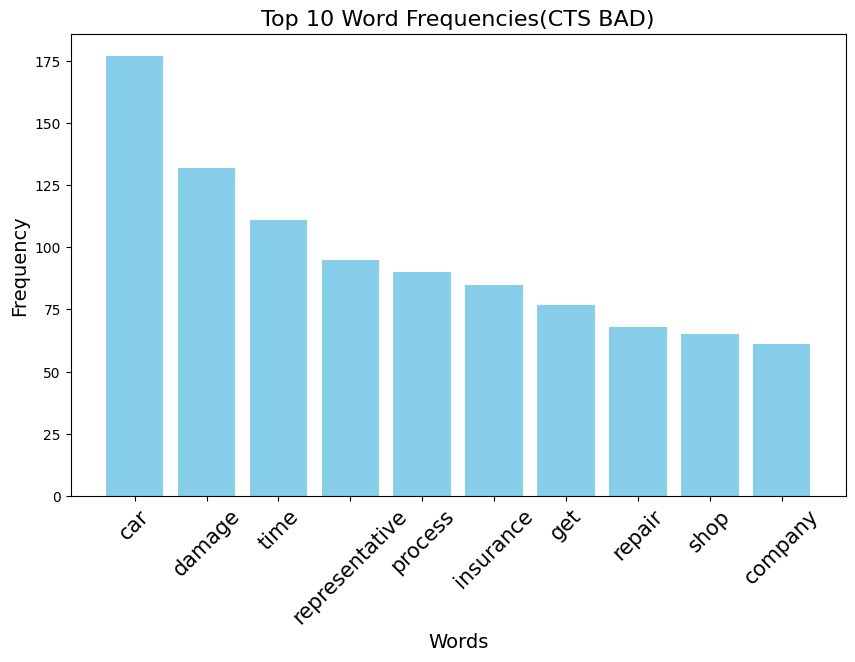

In [38]:
# removing stopwords from the the bad comments within the CTS dataset

bad_cts_no_sw= cts_comments['CTS - Reason Comments'][cts_comments['com_label']==1].apply(remove_stopwords)


# Combine all text into a single string
all_text = ' '.join(bad_cts_no_sw)

# Tokenize: Convert to lowercase, remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text)

# Count word frequencies
word_freq = Counter(tokens)

# Get the top N most common words
top_n = 10
common_words = word_freq.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies(CTS BAD)', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


I can't really get that much information from this, alot of the words are open ended such as car,damage, and time just to name a few.( a little too personal)

# Performing LDA (derving topics from bad comments) to see if i can get a summary of the complaints

### Creating model 

In [39]:
# Create document-term matrix
# basically converting words to number for model to read using vectorizer
vectorizer = CountVectorizer(max_features=500,stop_words='english')
# fitting model to data that has bad/negative feeback
doc_term_matrix = vectorizer.fit_transform(bad_cts_no_sw)

# Applying LDA and getting 3 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)


# computing scores 
print("Model Perplexity: ", lda_model.perplexity(doc_term_matrix), ', Model loglikely: ',lda_model.score(doc_term_matrix))

# Viweing topics along with the top 10 words 
topic_words = {}
words=10
vocab = vectorizer.get_feature_names_out()

# Mapping numbers back to words and displaying  
for topic, comp in enumerate(lda_model.components_):  
    word_idx = np.argsort(comp)[::-1][:words] 

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Model Perplexity:  475.841570061303 , Model loglikely:  -41077.96110729336
Topic: 0
  time, representative, stressful, claims, stress, process, easy, car, took, years
Topic: 1
  car, damage, repair, shop, time, rental, called, said, phone, body
Topic: 2
  car, insurance, loss, total, damage, time, bad, feel, pay, representative
Topic: 3
  damage, settlement, covered, insurance, contractor, check, work, adjuster, rep, hassle
Topic: 4
  process, problems, problem, rep, know, hit, communication, resolved, really, collision


### Analyzing model

The model’s loglikely score is too low indicating poor topics, also the perplexity score depicts this since its score is high ( Don't always follow this metric blindly). Mainly looking at this as a way to get some insight into the data, not actual topics since this will take some time to improve model results.  Another factor can be the amount of data that I have fed into the model.

(It might not have been enough to get some topics)

# Results for CTS ( bad comments)

As we can see, the topics aren't too clear but we can assume that most of the complaints are about the process of contacting/communicating with a representative can be  stressful/hassle and issues about the car insurance such as knowing whats covered and what to pay for. 

Based on the time plot earlier, I can possibly infer that these occur during the months of May or the months when the customers are doubled


# Analyzing comments for CTS good/postive comments

Building frequency plot based on comments that were labeled from sentiment model

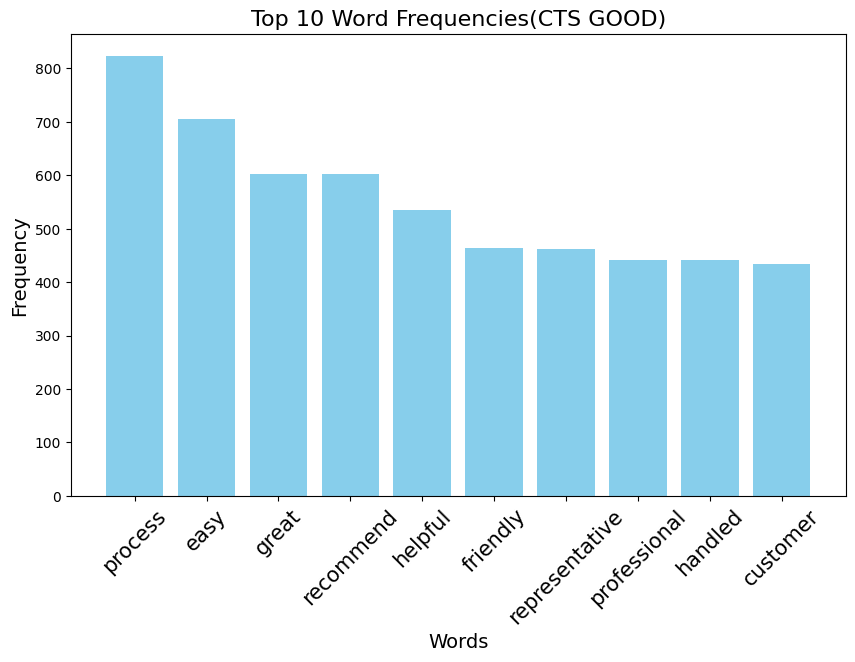

In [40]:
# removing stopwords from the the bad comments within the CTS dataset

good_cts_no_sw= cts_comments['CTS - Reason Comments'][cts_comments['com_label']==0].apply(remove_stopwords)


# Combine all text into a single string
all_text = ' '.join(good_cts_no_sw)

# Tokenize: Convert to lowercase, remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text)

# Count word frequencies
word_freq = Counter(tokens)

# Get the top N most common words
top_n = 10
common_words = word_freq.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies(CTS GOOD)', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


Based of off the frequency plot, we can say that the easy process and good character quality's from the representative are factors leading to a good satisfactory score  

###  Building LDA Model and analyzing 

Same steps that I used to build LDA model for bad comments just changed dataset

(Process will be very similar for all of the other models)

In [41]:
# Create document-term matrix
# basically converting words to number for model to read
vectorizer = CountVectorizer(max_features=500,stop_words='english')
# fitting model to data that has bad/negative feeback
doc_term_matrix = vectorizer.fit_transform(good_cts_no_sw)

# Applying LDA and getting 3 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)


# computing scores 
print("Model Perplexity: ", lda_model.perplexity(doc_term_matrix), ', Model loglikely: ',lda_model.score(doc_term_matrix))

# Viweing topics along with the top 10 words 
topic_words = {}
words=10
vocab = vectorizer.get_feature_names_out()

# Mapping numbers back to words and displaying  
for topic, comp in enumerate(lda_model.components_):  
    word_idx = np.argsort(comp)[::-1][:words] 

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Model Perplexity:  311.5572896581311 , Model loglikely:  -184230.1813176791
Topic: 0
  easy, handled, quickly, process, settlement, fair, quick, timely, fast, work
Topic: 1
  recommend, excellent, insurance, company, best, customer, kept, ease, informed, years
Topic: 2
  process, took, went, time, representative, make, shop, feel, care, like
Topic: 3
  customer, good, car, years, great, satisfied, experience, shop, rental, rep
Topic: 4
  helpful, friendly, professional, knowledgeable, great, prompt, representative, quick, efficient, response


Our loglikely and perplexity scores indicate a poor model but we can still get some useful information from this!

Ex.

Processes being fast, efficient, and easy while having knowledgeable representatives(from topic 0)

# CTS good comment summary

Overall we can say that some factors that lead to a good customer service score were how fast, timely, easy, and great the customer experience was along with the representatives being caring, knowledgeable, and courteous.


# Analysis for SCS bad/negative comments

Applying the same steps I did to the cts dataset but to the scs dataset to perfrom sentiment analysis to get labels for the scs comments

In [42]:
# Filtering and labeling data
scs_comments=scs[scs['SCS Reason Comments']!= "'-"].reset_index()

comment_label=[]
for i in range(len(scs_comments['SCS Reason Comments'])):
        if sia.polarity_scores((scs_comments['SCS Reason Comments'][i]))['compound']>=0:
            comment_label.append(0)
        else:
            comment_label.append(1)

scs_comments['com_label']=comment_label

Visual of class distribution for scs comments 

<Axes: title={'center': 'SCS Class Distribution'}, xlabel='com_label'>

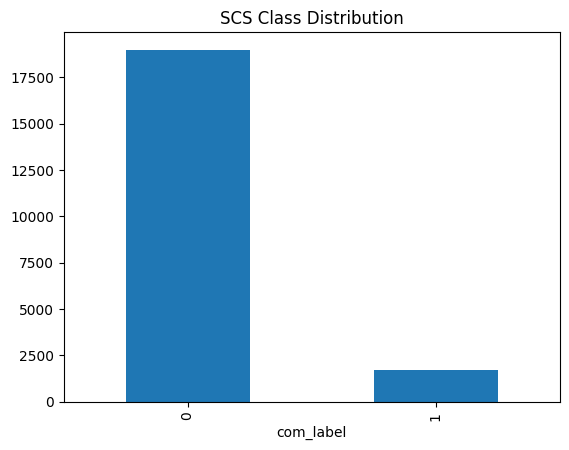

In [43]:
scs_comments['com_label'].value_counts().plot(kind='bar', title= 'SCS Class Distribution')

In [44]:
(scs_comments['com_label'].value_counts()[1]/scs_comments['com_label'].value_counts()[0])  *100

np.float64(9.125875968175352)

Roughly 9 percent left a negative comment

Major class imbalance so might be harder to analyze negative comments( Similar to CTS dataset)

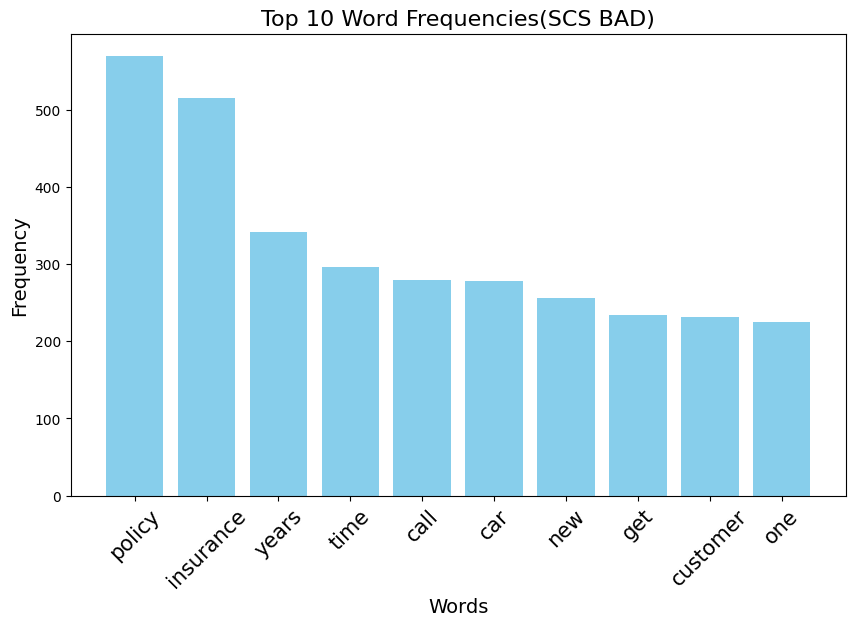

In [45]:
# removing stopwords from the the bad comments within the CTS dataset

bad_scs_no_sw= scs_comments['SCS Reason Comments'][scs_comments['com_label']==1].apply(remove_stopwords)


# Combine all text into a single string
all_text = ' '.join(bad_scs_no_sw)

# Tokenize: Convert to lowercase, remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text)

# Count word frequencies
word_freq = Counter(tokens)

# Get the top N most common words
top_n = 10
common_words = word_freq.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies(SCS BAD)', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


From the plot, we can infer that most people are having an issue with the calling process(maybe having a hard time getting a hold of a represenative) and the policy(car policies). 

(I'm trying to draw meaning from the data, so statements above might not actually be true )

### Making LDA model from bad comments

In [46]:
# Create document-term matrix
# basically converting words to number for model to read
vectorizer = CountVectorizer(max_features=500,stop_words='english')
# fitting model to data that has bad/negative feeback
doc_term_matrix = vectorizer.fit_transform(bad_scs_no_sw)

# Applying LDA and getting 3 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)


# computing scores 
print("Model Perplexity: ", lda_model.perplexity(doc_term_matrix), ', Model loglikely: ',lda_model.score(doc_term_matrix))

# Viweing topics along with the top 10 words 
topic_words = {}
words=10
vocab = vectorizer.get_feature_names_out()

# Mapping numbers back to words and displaying  
for topic, comp in enumerate(lda_model.components_):  
    word_idx = np.argsort(comp)[::-1][:words] 

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Model Perplexity:  388.2618518123642 , Model loglikely:  -111352.25881216701
Topic: 0
  policy, change, insurance, representative, auto, pay, years, time, information, payment
Topic: 1
  policy, rep, car, new, told, called, time, coverage, representative, took
Topic: 2
  reason, time, email, called, phone, policy, request, received, times, agent
Topic: 3
  price, recommend, insurance, year, rates, company, years, problem, claims, premium
Topic: 4
  insurance, years, customer, car, home, new, company, policy, experience, year


# SCS Bad comments summary

In the LDA model, policy appeared in multiple topics, but a lot of the words seem to hover around communication, rates/price, and time(years/months)

Hard to analyze the model and plot without removing words such as policy since it's clouding the model but overall some factors that lead to a bad satisfactory score are the policy, changes, and communicating/ getting a hold of the representative.

# Analyzing SCS good comments 

Creating frequency plot 

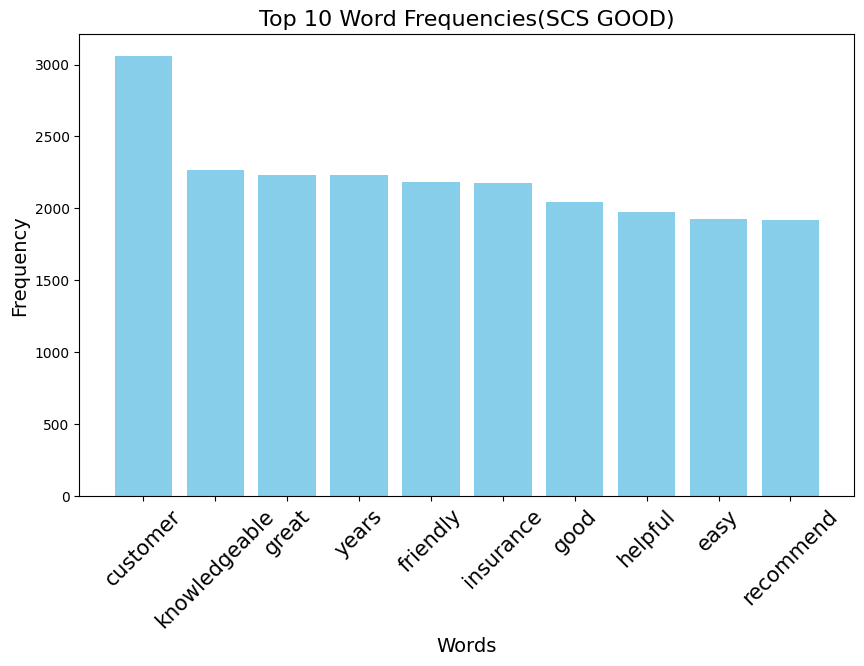

In [47]:
# removing stopwords from the the bad comments within the CTS dataset

good_scs_no_sw= scs_comments['SCS Reason Comments'][scs_comments['com_label']==0].apply(remove_stopwords)


# Combine all text into a single string
all_text = ' '.join(good_scs_no_sw)

# Tokenize: Convert to lowercase, remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text)

# Count word frequencies
word_freq = Counter(tokens)

# Get the top N most common words
top_n = 10
common_words = word_freq.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies(SCS GOOD)', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


Based on the frequency plot, we can tell that some factors may be how knowledgeable and friendly the representatives are

### Making LDA Model

In [48]:
# Create document-term matrix
# basically converting words to number for model to read
vectorizer = CountVectorizer(max_features=500,stop_words='english')
# fitting model to data that has bad/negative feeback
doc_term_matrix = vectorizer.fit_transform(good_scs_no_sw)

# Applying LDA and getting 3 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)


# computing scores 
print("Model Perplexity: ", lda_model.perplexity(doc_term_matrix), ', Model loglikely: ',lda_model.score(doc_term_matrix))

# Viweing topics along with the top 10 words 
topic_words = {}
words=10
vocab = vectorizer.get_feature_names_out()

# Mapping numbers back to words and displaying  
for topic, comp in enumerate(lda_model.components_):  
    word_idx = np.argsort(comp)[::-1][:words] 

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Model Perplexity:  261.1408885866385 , Model loglikely:  -622897.1730413557
Topic: 0
  knowledgeable, friendly, helpful, easy, representative, representatives, professional, quick, efficient, business
Topic: 1
  recommend, excellent, customer, insurance, company, best, business, high, friends, like
Topic: 2
  policy, insurance, car, new, change, time, coverage, called, representative, rep
Topic: 3
  great, good, customer, price, people, company, prices, rates, pricing, fair
Topic: 4
  years, customer, insurance, experience, claims, company, happy, satisfied, time, recent


Some more factors based on the LDA can be how fast and easy it was for the representatives to help them with their problem and the price.

# SCS good comments Summary

Overall some factors can be how knowledgeable the representatives are, the price, and how fast and easy the process can be.

# Analyzing REL bad comments

In [49]:
# Filtering data
rel_comments=rel[rel['REL Primary Reason Comments']!= "'-"].reset_index()
rel_comments = rel_comments[rel_comments['REL Primary Reason Comments'].apply(is_not_integer)].reset_index()

# Assigning labels 
comment_label=[]
for i in range(len(rel_comments['REL Primary Reason Comments'])):
        if sia.polarity_scores((rel_comments['REL Primary Reason Comments'][i]))['compound']>=0:
            comment_label.append(0)
        else:
            comment_label.append(1)

rel_comments['com_label']=comment_label

Visual

<Axes: title={'center': 'REL Class Distribution'}, xlabel='com_label'>

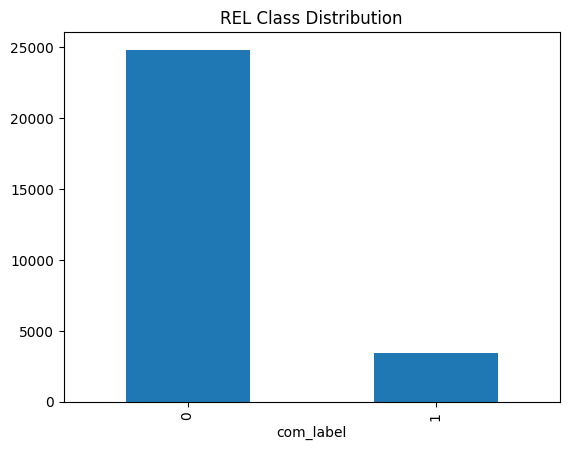

In [50]:
rel_comments['com_label'].value_counts().plot(kind='bar',title= 'REL Class Distribution')

In [51]:
(rel_comments['com_label'].value_counts()[1]/rel_comments['com_label'].value_counts()[0]) * 100

np.float64(13.834931893286049)

Around 14 percent of the people left a negative comment

More data that CTS and SCS so hopefully better models but overall similar distribution

### Creating word frequency plot 

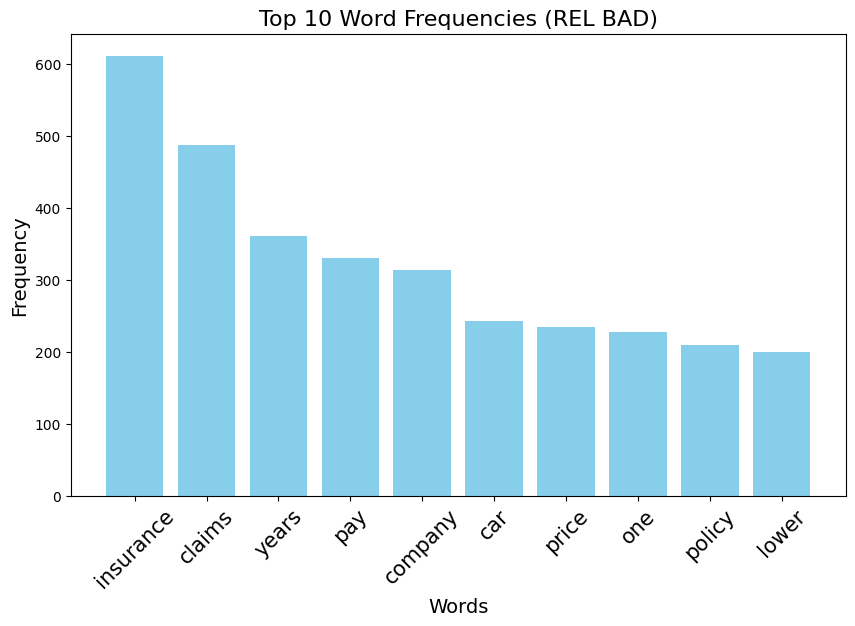

In [52]:
# removing stopwords from the the bad comments within the CTS dataset

bad_rel_no_sw= rel_comments['REL Primary Reason Comments'][rel_comments['com_label']==1].apply(remove_stopwords)


# Combine all text into a single string
all_text = ' '.join(bad_rel_no_sw)

# Tokenize: Convert to lowercase, remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text)

# Count word frequencies
word_freq = Counter(tokens)

# Get the top N most common words
top_n = 10
common_words = word_freq.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies (REL BAD)', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


This plot doesn't tell much info but some factors that maybe the pay and claims(mainly the auto area of the company)

### Making LDA model

In [53]:
# Create document-term matrix
# basically converting words to number for model to read
vectorizer = CountVectorizer(max_features=500,stop_words='english')
# fitting model to data that has bad/negative feeback
doc_term_matrix = vectorizer.fit_transform(bad_rel_no_sw)

# Applying LDA and getting 3 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)


# computing scores 
print("Model Perplexity: ", lda_model.perplexity(doc_term_matrix), ', Model loglikely: ',lda_model.score(doc_term_matrix))

# Viweing topics along with the top 10 words 
topic_words = {}
words=10
vocab = vectorizer.get_feature_names_out()

# Mapping numbers back to words and displaying  
for topic, comp in enumerate(lda_model.components_):  
    word_idx = np.argsort(comp)[::-1][:words] 

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Model Perplexity:  356.69981899601913 , Model loglikely:  -99331.27227439127
Topic: 0
  claims, years, policy, hassle, auto, went, quickly, handled, month, customer
Topic: 1
  insurance, lower, price, rates, companies, year, reason, claims, premiums, competitive
Topic: 2
  pay, insurance, need, company, time, low, want, like, customer, money
Topic: 3
  car, damage, problem, years, home, ago, claims, handled, paid, house
Topic: 4
  company, experience, reputation, bad, insurance, good, fault, claims, question, difficult


# REL Bad comments Summary
It's hard to get information from this model but negative comments on the policies and claims(auto and home), pricing/rates, and time

# For REL good comments

Making frequency plot 

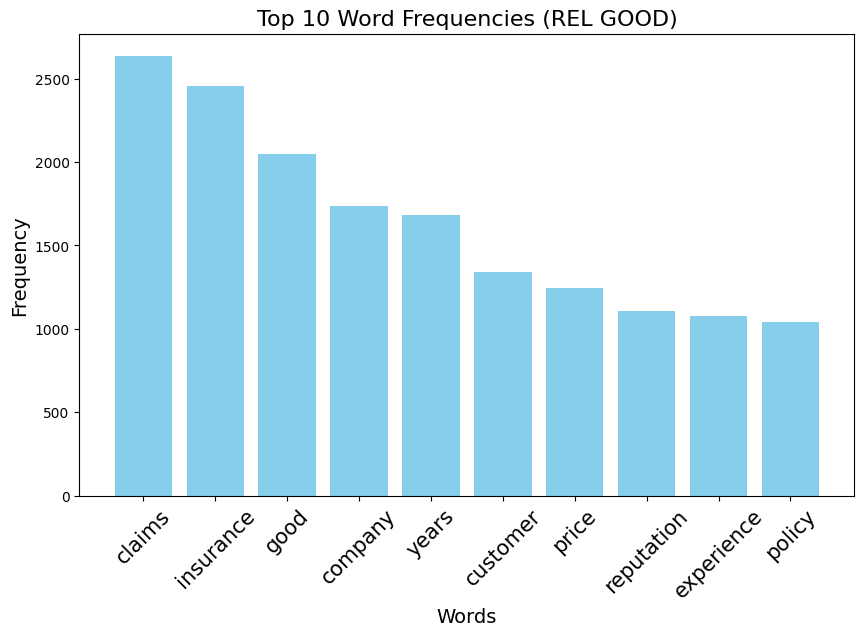

In [54]:
# removing stopwords from the the bad comments within the CTS dataset

good_rel_no_sw= rel_comments['REL Primary Reason Comments'][rel_comments['com_label']==0].apply(remove_stopwords)


# Combine all text into a single string
all_text = ' '.join(good_rel_no_sw)

# Tokenize: Convert to lowercase, remove punctuation, and split into words
tokens = re.findall(r'\b\w+\b', all_text)

# Count word frequencies
word_freq = Counter(tokens)

# Get the top N most common words
top_n = 10
common_words = word_freq.most_common(top_n)
words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Top {top_n} Word Frequencies (REL GOOD)', fontsize=16)
plt.xticks(rotation=45,fontsize=15)
plt.show()


Some factors based on the frequency plot may be reputation, the overall experience, and price

### Making LDA Model

In [55]:
# Create document-term matrix
# basically converting words to number for model to read
vectorizer = CountVectorizer(max_features=500,stop_words='english')
# fitting model to data that has bad/negative feeback
doc_term_matrix = vectorizer.fit_transform(good_rel_no_sw)

# Applying LDA and getting 3 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(doc_term_matrix)


# computing scores 
print("Model Perplexity: ", lda_model.perplexity(doc_term_matrix), ', Model loglikely: ',lda_model.score(doc_term_matrix))

# Viweing topics along with the top 10 words 
topic_words = {}
words=10
vocab = vectorizer.get_feature_names_out()

# Mapping numbers back to words and displaying  
for topic, comp in enumerate(lda_model.components_):  
    word_idx = np.argsort(comp)[::-1][:words] 

    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
    
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Model Perplexity:  305.09808066154136 , Model loglikely:  -496236.33568244416
Topic: 0
  claims, years, customer, handled, excellent, helpful, quickly, time, ago, care
Topic: 1
  good, price, experience, reason, questions, customer, reasonable, competitive, value, best
Topic: 2
  policy, easy, insurance, like, auto, needed, home, need, good, make
Topic: 3
  reputation, coverage, response, best, answer, questions, quick, previous, fair, question
Topic: 4
  insurance, company, important, high, rates, companies, consumer, cost, reports, year


# REL Good comments summary 

Overall some factors from the people who have no policy changes can be the companies repuation, pricing/rates, how quick the process is, and represenatives 

# Answering first question

Merging the Prim response categories from all 3 datasets to make final visual

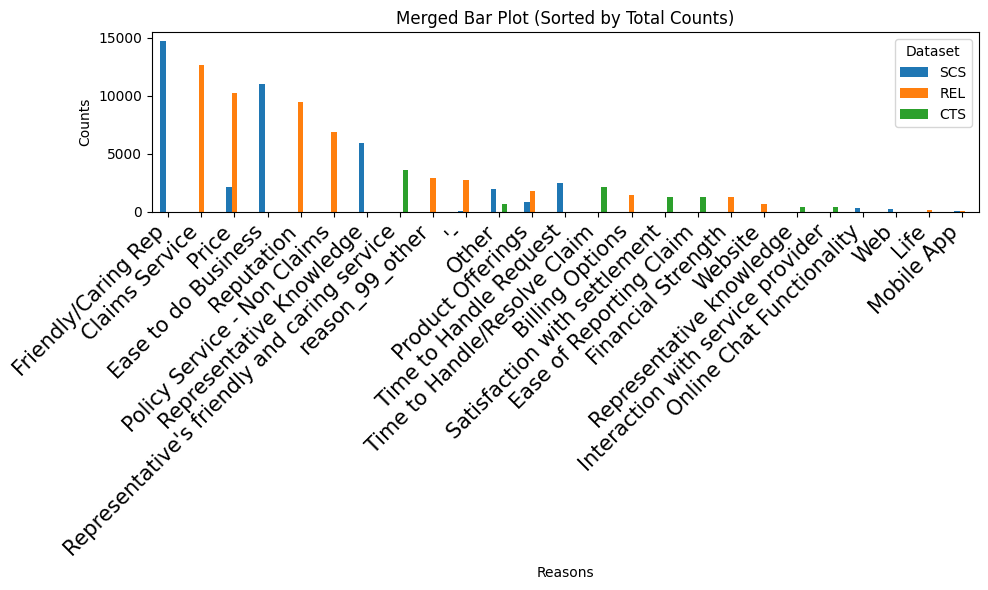

In [56]:
# Get value counts for each dataset
scs_counts = scs['SCS Primary Reason'].value_counts()
rel_counts = rel['REL Primary Reason'].value_counts()
cts_counts = cts['CTS - Prim Reason'].value_counts()

# Combine into a single DataFrame
merged = pd.DataFrame({
    'SCS': scs_counts,
    'REL': rel_counts,
    'CTS': cts_counts
}).fillna(0)

# Calculate total counts for each reason (only used for sorting for visual)
merged['Total'] = merged.sum(axis=1)

# Sort the DataFrame by total counts
merged_sorted = merged.sort_values(by='Total', ascending=False)

# Remove the Total column before plotting 
merged_sorted = merged_sorted.drop('Total', axis=1)

# Plot with sorted categories
ax = merged_sorted.plot(kind='bar', figsize=(10, 6))
plt.title('Merged Bar Plot (Sorted by Total Counts)')
plt.xlabel('Reasons')
plt.ylabel('Counts')
plt.legend(title='Dataset')
plt.xticks(rotation=45, ha='right',fontsize=15)
plt.tight_layout()
plt.show()


As shown by the plot above, OVERALL the top primary reasons why customers leave a good score are because the representatives are friendly/caring, the price, the claims service, ease of business, the company's reputation, policy service, and representatives’ knowledge.

Some things to work on are the mobile app, website, online chat functionality, and Life.


# Being more specific with the audience

To be more specific, people who underwent the claim process(CTS) are pleased with the representatives’ friendly and caring service, the time to resolve the claims, ease of reporting claims, and satisfaction with the settlement. Some improvements can be the website and mobile app, and the time it takes/process of connecting with a representative.

For the people who have no changes to their policy within a year (REL), they are satisfied with the claim service, price, company reputation, and policy service. Some improvements can be life(?), the mobile app, and website, rates, and what is covered on the policy.

For the people who have changes to their policy(SCS), they are satisfied with the friendly/caring representative, the ease of business, the reps knowledge, time to handle requests only with the price. Some things to work on are the mobile app, website, and online chat functionality along with product offerings and policy education (what’s covered and what changes affect the new policy)






<Axes: xlabel='CTS - Prim Reason'>

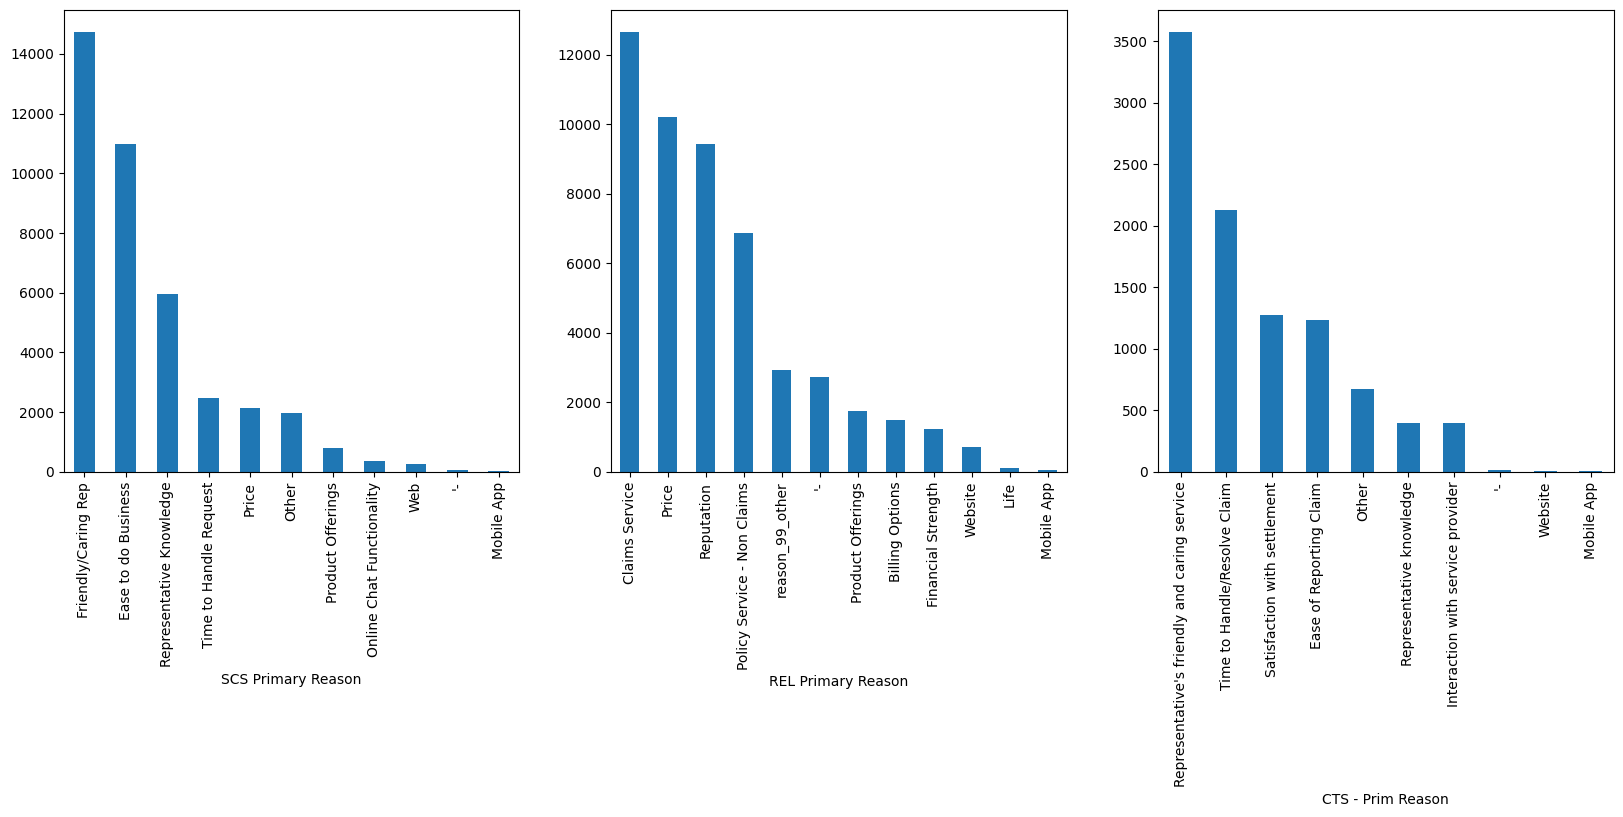

In [57]:
fig,axs= plt.subplots(1,3,figsize=(20,6))

scs['SCS Primary Reason'].value_counts().plot(kind='bar',ax=axs[0])
rel['REL Primary Reason'].value_counts().plot(kind='bar',ax=axs[1])
cts['CTS - Prim Reason'].value_counts().plot(kind='bar',ax=axs[2])

# Actual answer for Question 2

After Analyzing the comments and the categories, Some factors that can lead to customer satisfaction can be the rates, representatives’ good character and knowledgeability, company reputation, and how fast and easy the process is.

Some factors that can lead to dissatisfaction can be the price/rates, how hard it is to get a hold of the representatives and communicate with the company, and policies to name a few


# Actual answer for Question 3

Surestore can improve customer experience by improving how easy it can be to get in touch with a representative and the time to connect with them and enter the process since this process is so fast and easy to use. They can also improve the websites and the mobile app since people from all 3 datasets agreed that the app and website weren’t a huge reason for their satisfaction.

A lot of the comments talked about the policy so maybe improving this process for those who are going to have a policy change.

# Improvements
- Could improve the frequency plots by spending more time removing words from the frequency chart to make it clearer.

- Also could play around with LDA models by removing some more words (such as time or car, policy, etc) to at least get a better overall topic since the models were all clouded. This reflected on the perplexity and loglikely scores, I decided not to do this and analyze the base model because I can end up going down a rabbit hole trying to find the best parameters and words to remove.

- Could perform more EDA such as looking into each comment based on the Primary Response that they choose.

- Could've performed EDA on the 'Other' column from the SCS and REL dataset.

- Make a new dataset by combining all comments from all 3 datasets and then creating frequency plots and LDA models based on class.

- Perform EDA on the comments as a whole per dataset to get better overall topics. (Only issue is that the bad comments/topics might be clouded by the good topics).

- Try other vectorizer methods such as TFIDF or, doctovec, word2vec, and play with the parameters.

- See how the satisfaction or dissatisfaction is associated with the months.( Any anomalies or more/all negative comments during busy months)

- look into what the primary reasoning is based on if the person chose a negative or positive comment.




# Question for reviewers

- How do you plan on handling the 'other' category since less than 1 percent is leaving actually answering this? Also if I'm following Vangaurd’s mission statement/ motto (investment for all) shouldn't I make sure that all opinions and comments are heard, although it’s only a small subset that wouldn't affect the majority decision based on their feedback?

- How was this data pulled because there are a ton of positive comments. Are the overall customers satisfied with the process or is this data biased? 

- Time is a big factor here for good and bad satisfaction scores, but time in what? Is it the time to fill out the claim/change policy, time to connect to a representative, duration of the policy, etc.